In [3]:
import pandas as pd
import lightkurve as lk
import matplotlib
import matplotlib.pyplot as plt
from astroquery.mast import Catalogs

### Step 1
have a list of deliveries and what we vetted and what the individual and final dispositions were and what day they were vetted on

In [3]:
# insert code here

### Step 2
load in the list of targets from TEV as a csv file 

In [4]:
table = pd.read_csv("/home/jovyan/spoc-s02.csv")

In [5]:
table.head()

,src,tic_id,toi_id,Disposition,RA,Dec,Tmag,Tmag Err,Epoc,Epoc Err,...,Centroid offset,Master,SG1a,SG1b,SG2,SG3,SG4,SG5,Created,Updated
0,spoc,144440290,00222.01,PC,359.161519,-44.719088,8.723,0.017,1376.544000,NaN,...,False,3,4,3,3,4,4,4,2018-11-16 21:15:19.213203+00:00,2018-11-26 23:22:27.615763+00:00
1,spoc,441053949,?.01,PC,359.275500,-17.077000,12.913,0.060,1364.688846,0.003035,...,False,3,4,3,3,4,4,4,2018-11-16 21:15:21.692954+00:00,2018-11-26 22:37:51.753648+00:00
2,spoc,441056702,?.01,PC,359.518900,-15.066200,11.051,0.040,NaN,NaN,...,False,3,4,3,3,4,4,4,2018-11-16 21:15:21.619223+00:00,2018-11-26 22:31:30.714472+00:00
3,spoc,326453034,00223.01,PC,339.677665,-25.631723,10.206,0.018,1355.957510,0.002649,...,False,3,4,3,3,4,4,4,2018-11-16 21:15:25.490004+00:00,2018-11-26 22:29:30.681603+00:00
4,spoc,70797900,00224.01,PC,1.977400,-29.979000,10.950,0.040,1365.843681,0.000240,...,False,3,4,3,3,4,4,4,2018-11-16 21:15:40.726719+00:00,2018-11-26 21:27:33.027518+00:00


### step 3
make a pretty plot
(of one light curve)

In [7]:
tic1 = table.tic_id[0]
lcf = lk.search_lightcurvefile(tic1).download()

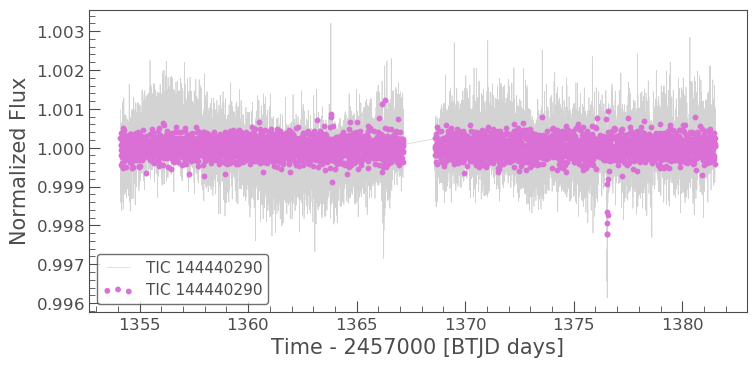

In [14]:
lc = lcf.PDCSAP_FLUX
ax = lc.plot(zorder=1,c='lightgrey')
lc.flatten(sigma=3).bin(binsize=5).scatter(ax=ax,c="orchid",s=10,alpha=1.0,zorder=2)

### step 4

apply to a bunch of light curves

In [10]:
# set of first five tics in table
mini = table.iloc[1:5,] 

# data frame of light curve file collections for each individual tic
mini["lcfcs"] = mini.tic_id.apply( lambda x : lk.search_lightcurvefile(x).download_all())

mini.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,src,tic_id,toi_id,Disposition,RA,Dec,Tmag,Tmag Err,Epoc,Epoc Err,...,Master,SG1a,SG1b,SG2,SG3,SG4,SG5,Created,Updated,lcfcs
1,spoc,441053949,?.01,PC,359.275500,-17.077000,12.913,0.060,1364.688846,0.003035,...,3,4,3,3,4,4,4,2018-11-16 21:15:21.692954+00:00,2018-11-26 22:37:51.753648+00:00,[TessLightCurveFile(TICID: 441053949)]
2,spoc,441056702,?.01,PC,359.518900,-15.066200,11.051,0.040,NaN,NaN,...,3,4,3,3,4,4,4,2018-11-16 21:15:21.619223+00:00,2018-11-26 22:31:30.714472+00:00,[TessLightCurveFile(TICID: 441056702)]
3,spoc,326453034,00223.01,PC,339.677665,-25.631723,10.206,0.018,1355.957510,0.002649,...,3,4,3,3,4,4,4,2018-11-16 21:15:25.490004+00:00,2018-11-26 22:29:30.681603+00:00,[TessLightCurveFile(TICID: 326453034)]
4,spoc,70797900,00224.01,PC,1.977400,-29.979000,10.950,0.040,1365.843681,0.000240,...,3,4,3,3,4,4,4,2018-11-16 21:15:40.726719+00:00,2018-11-26 21:27:33.027518+00:00,[TessLightCurveFile(TICID: 70797900)]


In [26]:
for index, row in mini.iterrows():
    print(row['Period'])

nan
nan
14.445917999999999
nan


### step 5

make a pretty plot for a bunch of tces
   *  normalize PDCSAP flux
   *  fold it
   *  plot it as is
   *  bin and plot as a scatterplot over top
    

In [28]:
# apply some combination of cleanup methods to the lightcurve
polish = lambda x: x.PDCSAP_FLUX.normalize()

# stitch light curves together for each collection 
for index, row in mini.iterrows():
    # print(len(row['lcfcs']))
    lc = polish(row['lcfcs'][0])
    for l in row['lcfcs'][1:]:
        lc = lc.append(polish(l))
    print(row['Disposition'])
    lcfold = lc.fold(row['Period'], row['Epoc'])
    # ax = lc.plot(zorder=1,c='lightgrey')
    # lc.bin(binsize=5).scatter(ax=ax,c="orchid",s=10,alpha=1.0,zorder=2)
    # print("{}.png".format(row['tic_id']))
    # plt.savefig("{}.png".format(row['tic_id']))
    # to png
    

PC
PC
PC
PC


### step 6

batch them up in a nice grid

NameError: name 'x' is not defined

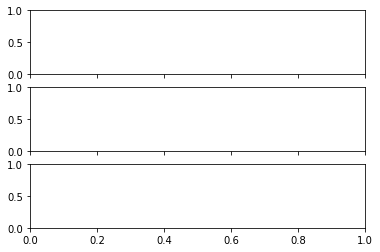

In [12]:
# matplotlib example code
f, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, sharey=True)
ax1.plot(x, y)
ax1.set_title('Sharing both axes')
ax2.scatter(x, y)
ax3.scatter(x, 2 * y ** 2 - 1, color='r')
# Fine-tune figure; make subplots close to each other and hide x ticks for
# all but bottom plot.
f.subplots_adjust(hspace=0)
plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)

## pseudocode

get collection of lightcurves for a tic

clean them up

stich the lcs together

fold the light curves

plot the clean light curve for each tic 

print a "gallery" of lcs 
    use mpl subplots or mpl grid, gridspec?
    appreciate scale

## to-do list

group them by tic

check if we’ve seen them before in previous deliveries

check wtv to see if they’ll be in future sectors

query gaia for brightnesses or query mast for gaia brightnesses
   * main star
   * nearby stars

check if nearby stars are known

check if nearby stars are TOIs

check if nearby stars are TICs

check if nearby stars are false positives

has it been marked a false positive on exofop

has it been marked a known planet on exofop